In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data understanding

In [14]:
df_sales = pd.read_csv("../data/raw/sales_train.csv")
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [15]:
df_items = pd.read_csv("../data/raw/items.csv")
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [16]:
df_item_categories = pd.read_csv("../data/raw/item_categories.csv")
df_item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [17]:
df_shops = pd.read_csv("../data/raw/shops.csv")
df_shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [18]:
df_test = pd.read_csv("../data/raw/test.csv")
print(f"Shape: {df_test.shape}")
df_test.head()

Shape: (214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


**First Impressions**

- as stated in challenge's description, the test set has only one month while the train set has days/day/item.
- as stated in challenge's description, and at first glance, the other provided files do not add any value to the forecast analysis.

## Exploring df_sales

In [19]:
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [20]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [21]:
df_sales["year_month"] = df_sales["date"].str.slice(start=-4) + df_sales["date"].str.slice(start=3, stop=5)
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year_month
0,02.01.2013,0,59,22154,999.00,1.0,201301
1,03.01.2013,0,25,2552,899.00,1.0,201301
2,05.01.2013,0,25,2552,899.00,-1.0,201301
3,06.01.2013,0,25,2554,1709.05,1.0,201301
4,15.01.2013,0,25,2555,1099.00,1.0,201301


In [22]:
print(f"""Unique values:
      - year_month: {df_sales["year_month"].nunique()}
      - date_block_num: {df_sales["date_block_num"].nunique()}
      - shop_id: {df_sales["shop_id"].nunique()}
      - item_id: {df_sales["item_id"].nunique()}""")

Unique values:
      - year_month: 34
      - date_block_num: 34
      - shop_id: 60
      - item_id: 21807


## Exploring df_test

In [23]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [24]:
print(f"""Unique values:
      - shop_id: {df_test["shop_id"].nunique()}
      - item_id: {df_test["item_id"].nunique()}""")

Unique values:
      - shop_id: 42
      - item_id: 5100


## Verifying if the values in df_test exist in df_sales

Here I would like to verify if the shop_id and item_id values are in train dataset.

In [25]:
df_test.tail()

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


In [26]:
df = df_test.groupby(by=["shop_id", "item_id"]).agg({"ID":["count", "nunique"]})
df.head()

ID        
                count nunique
shop_id item_id              
2       30          1       1
        31          1       1
        32          1       1
        33          1       1
        38          1       1

In [27]:
df[("ID")].value_counts()

count  nunique
1      1          214200
dtype: int64

In [28]:
df_sales.head()
# df_sales.groupby(by=["year_month", "shop_id", "item_id"]).agg({"ID":["count", "nunique"]})
# df_sales.groupby(by=["shop_id", "item_id"]).size()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year_month
0,02.01.2013,0,59,22154,999.00,1.0,201301
1,03.01.2013,0,25,2552,899.00,1.0,201301
2,05.01.2013,0,25,2552,899.00,-1.0,201301
3,06.01.2013,0,25,2554,1709.05,1.0,201301
4,15.01.2013,0,25,2555,1099.00,1.0,201301


In [29]:
df = df_test.merge(df_sales, how='left', on=["shop_id", "item_id"])
len(df.loc[df["ID"].isnull(), "item_id"])

0

In [30]:
df = df_sales.merge(df_test, how='left', on=["shop_id", "item_id"])
df = df.loc[df["ID"].isnull(), ["shop_id", "item_id"]]
len(df)

1711410

## Creating the train dataset according to the output format

In [31]:
df_train = df_sales.copy()
df_train = df_train.groupby(by=["year_month","shop_id", "item_id"]).agg({"item_cnt_day": "sum"}).rename(columns={"item_cnt_day": "item_cnt_month"}).reset_index()
df_train["year"] = df_train["year_month"].str.slice(stop=4).astype(int)
df_train["month"] = df_train["year_month"].str.slice(start=-2).astype(int)
df_train = df_train[["year", "month", "shop_id", "item_id", "item_cnt_month"]]
df_train.head()

,year,month,shop_id,item_id,item_cnt_month
0,2013,1,0,32,6.0
1,2013,1,0,33,3.0
2,2013,1,0,35,1.0
3,2013,1,0,43,1.0
4,2013,1,0,51,2.0


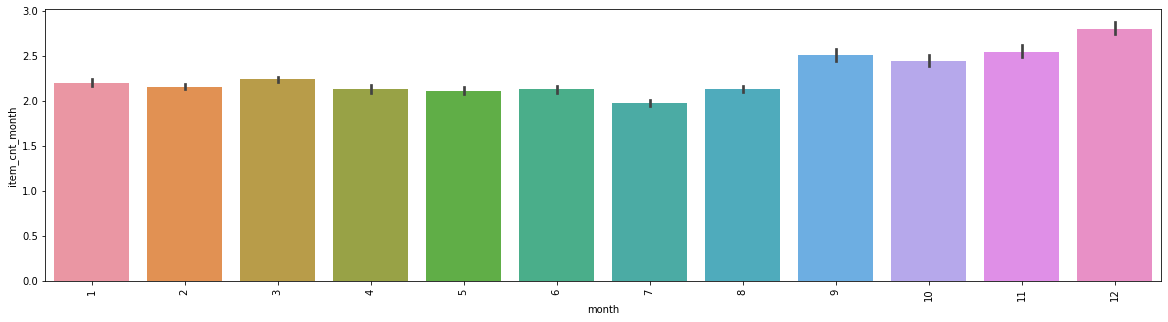

In [32]:
# plt.subplots(nrows=3, ncols=12, figsize=(20,5))
# for date_block in df_train["date_block_num"].unique():

plt.subplots(figsize=(20,5))
plt.xticks(rotation=90)
sns.barplot(x="month", y="item_cnt_month", data=df_train);

In [33]:
lst_train_columns = df_train.columns.tolist()
lst_train_columns.remove("item_cnt_month")
lst_train_columns

['year', 'month', 'shop_id', 'item_id']

In [34]:
df_test_mod = df_test.copy()
df_test_mod["year"] = 2015
df_test_mod["month"] = 11
df_test_mod = df_test_mod[lst_train_columns]

df_test_mod.head()

,year,month,shop_id,item_id
0,2015,11,5,5037
1,2015,11,5,5320
2,2015,11,5,5233
3,2015,11,5,5232
4,2015,11,5,5268


# Baseline model

Let's get a baseline from a random forest model.

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as rmse
from sklearn.model_selection import train_test_split

In [39]:
%%time

X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop("item_cnt_month", axis=1), df_train["item_cnt_month"], train_size=.2, random_state=42, shuffle=True, stratify=None)

model = RandomForestRegressor(
    n_estimators=500, criterion='mse', max_depth=10, min_samples_split=3, min_samples_leaf=2, min_weight_fraction_leaf=0.0,
    max_features=len(X_train.columns)-2, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True,
    oob_score=False, random_state=42, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None, n_jobs=-1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse(y_test, y_pred)

Wall time: 37.3 s


47.44623244298184

In [48]:
X_test["y_test"] = y_test
X_test["y_pred"] = y_pred
X_test["y_pred_round"] = np.rint(y_pred)
X_test["dif"] = X_test["y_pred"] - X_test["y_test"]
X_test.sort_values(by="dif", ascending=False).head()

print(f"RMSE com inteiros: {rmse(y_test, np.rint(y_pred))}")

X_test.head()

RMSE com inteiros: 47.55939175017478


,year,month,shop_id,item_id,y_pred,y_test,dif,y_pred_round
954911,2014,6,38,2196,2.180097,2.0,0.180097,2.0
1043055,2014,8,31,9964,1.991705,7.0,-5.008295,2.0
639825,2013,12,22,5622,3.219817,3.0,0.219817,3.0
257249,2013,5,25,3468,2.642373,1.0,1.642373,3.0
1596414,2015,10,37,5820,2.107022,3.0,-0.892978,2.0


In [43]:
# Verificar as diferenças.
# É importante verificar que a quantidade vendida é um número inteiro.

X_test[X_test["dif"]<0]

,year,month,shop_id,item_id,y_pred,y_test,dif
1043055,2014,8,31,9964,1.991705,7.0,-5.008295
1596414,2015,10,37,5820,2.107022,3.0,-0.892978
297461,2013,6,5,17768,1.723509,3.0,-1.276491
531441,2013,10,19,18442,1.703524,2.0,-0.296476
635942,2013,12,18,13518,1.929847,12.0,-10.070153
1608020,2015,10,58,5643,1.980608,3.0,-1.019392
710370,2014,1,28,11592,2.158488,7.0,-4.841512
295017,2013,5,59,19662,1.740285,2.0,-0.259715
438964,2013,8,31,8664,1.909795,5.0,-3.090205
1224664,2014,12,31,7863,12.658410,24.0,-11.341590


In [42]:
df_test_mod_results = df_test_mod.copy()
y_pred_df_test = model.predict(df_test_mod_results)
df_test_mod_results["y_pred"] = y_pred_df_test

df_test_mod_results.head()

,year,month,shop_id,item_id,y_pred
0,2015,11,5,5037,1.931578
1,2015,11,5,5320,1.922045
2,2015,11,5,5233,1.933484
3,2015,11,5,5232,1.925436
4,2015,11,5,5268,1.922761


# Adding new features and transforming others

In [38]:
df_train_mod = df_train.copy()
df_train_mod["month_sin"] = np.sin(2 * np.pi * df_train_mod["month"]/12.0)
df_train_mod["month_cos"] = np.cos(2 * np.pi * df_train_mod["month"]/12.0)
df_train_mod.drop("month", axis=1, inplace=True)

df_train_mod["year"] = df_train_mod["year"] - df_train_mod.loc[0, "year"] + 1

df_train_mod = df_train_mod[['year', 'month_sin', 'month_cos', 'shop_id', 'item_id', 'item_cnt_month']]
df_train_mod.head()

,year,month_sin,month_cos,shop_id,item_id,item_cnt_month
0,1,0.5,0.866025,0,32,6.0
1,1,0.5,0.866025,0,33,3.0
2,1,0.5,0.866025,0,35,1.0
3,1,0.5,0.866025,0,43,1.0
4,1,0.5,0.866025,0,51,2.0


In [12]:
%%time

X_train, X_test, y_train, y_test = train_test_split(
    df_train_mod.drop("item_cnt_month", axis=1), df_train_mod["item_cnt_month"], train_size=.2, random_state=42, shuffle=True, stratify=None)

model = RandomForestRegressor(
    n_estimators=500, criterion='mse', max_depth=10, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
    max_features=len(X_train.columns)-2, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True,
    oob_score=False, random_state=42, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None, n_jobs=-1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse(y_test, y_pred)

NameError: name 'train_test_split' is not defined